In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import random
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from datetime import datetime

from Header import load_table
from Header import period
from Header import month_list
from Header import monthly_returns
from Header import tree_to_table

In [49]:
def period(start, end, distance = 1):
    s = start.split('-')
    e = end.split('-')
    y1 = int(s[0])
    m1 = int(s[1])
    d1 = int(s[2])
    y2 = int(e[0])
    m2 = int(e[1])
    d2 = int(e[2])
    dates = []
    dates.append(start)
    while((y1 < y2) or (y1 == y2 and m1 < m2) or (y1 == y2 and m1 == m2 and d1 <= d2 - distance)):
        if(np.isin(m1, [1,3,5,7,8,10])):
            d1 += distance
            if(d1 > 31):
                d1 = d1%31
                m1 += 1
        elif(m1 == 12):
            d1 += distance
            if(d1 > 31):
                d1 = d1%31
                m1 = 1
                y1 += 1
        elif(np.isin(m1, [4,6,9,11])):
            d1 += distance
            if(d1 > 30):
                d1 = d1%30
                m1 += 1
        elif(m1 == 2):
            d1 += distance
            if((y1/4 - math.floor(y1/4)) == 0):
                if(d1 > 29):
                    d1 = d1%29
                    m1 += 1
            else:
                if(d1 > 28):
                    d1 = d1%28
                    m1 += 1
        else:
            print("Error: month > 12")
        dates.append(str(y1)+'-'+str(m1)+'-'+str(d1))
        df = pd.DataFrame(dates,columns=['Date'])
        df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df.set_index(['Date'])
        #df = pd.to_datetime(df)
    return df
def month_list(start_date,end_date):
    start_d = start_date.split('-')[2]
    start_m = start_date.split('-')[1]
    start_y = start_date.split('-')[0]
    end_d = end_date.split('-')[2]
    end_m = end_date.split('-')[1]
    end_y = end_date.split('-')[0]
    n_months = ((int(end_y) - int(start_y))*12) + ((int(end_m) - int(start_m)))
    months = []
    y = int(start_y)
    for i in range(n_months):
        m = ((int(start_m) - 1 + i)%12) + 1
        if(((int(start_m)-1 + i)%12) == 0 and i != 0):
            y += 1 
        date = str(y) + '-' + str(m) + '-' + str(1)
        months.append(date)
    months = pd.DataFrame(months, columns=['Date'])
    months['Date'] =  pd.to_datetime(months['Date'], format='%Y-%m-%d')
    months = months.set_index(['Date'])
    return months

def load_table(path, dvd = True):
    files = os.listdir(path)
    df_list = list()
    for i in range(len(files)):
        table = pd.read_csv(path+files[i],index_col='Date',parse_dates=True,encoding="utf-16-le")[['Close']]
        name = files[i].replace(".csv","")
        table.columns = [name]
        df_list.append(table)
    df = df_list[0]
    for df_ in df_list[1:]:
        df = pd.concat([df,df_], axis=1)
    df.fillna(method='ffill',inplace=True)
    return df_list, df

def monthly_returns(price, start_date, end_date):
    months = month_list(start_date,end_date)
    returns_df = pd.DataFrame(months.index,columns=['Date'])
    for col in price.columns:
        values = []
        for i in range(len(months)-1):
            idx = price.loc[(price.index >= months.index[i]) & (price.index < months.index[i+1])].index
            v = price.loc[idx,col].iloc[0]
            values = np.append(values,v)
            values = pd.DataFrame(values,columns=[col])
        returns_df = pd.concat([returns_df,values],axis=1)
    returns_df.drop(len(months)-1,axis=0,inplace=True)
    returns_df = returns_df.set_index("Date")
    returns = returns_df.pct_change()*100
    returns = returns.drop(returns.index[0], axis=0)
    return returns_df

def tree_to_table(tree, name_str):
    n_gen = len(tree)
    n_chrom = len(tree[0])
    name = []
    gen = []
    chrom = []
    ret = []
    vol = []
    sr = []
    res = []
    for i in range(n_gen):
        for j in range(n_chrom):
            name.append(name_str)
            gen.append(i)
            chrom.append(j)
            ret.append(tree[i][j].get_expected_return())
            vol.append(tree[i][j].get_volatility())
            sr.append(tree[i][j].get_sharpe_ratio())
    d = {'name': name, 'generation': gen, 'chromosome': chrom, 'return': ret, 'volatility': vol, 'sharpe_ratio': sr}
    df = pd.DataFrame(data=d)
    return df

In [50]:
class Portfolio:
    def __init__(self, returns_df, corr_matrix, risk_free):
        self.returns = returns_df
        self.corr = corr_matrix
        self.description = self.returns.describe()
        self.n_assets = self.returns.shape[1]
        self.risk_free = risk_free
        self.initialize_weights()
        self.set_expected_return()
        self.set_volatility()
        self.set_sharpe_ratio()
        return None
    def initialize_weights(self):
        self.weights = np.random.rand(self.n_assets)
        self.weights = (self.weights/self.weights.sum())
        return None
    def set_weights(self, weights):
        self.weights = (weights/weights.sum())
        self.set_discrete_weights = self.weights
        return None
    def set_expected_return(self):
        weighted = self.weights*self.description.loc['mean']
        self.expected_return = weighted.sum().round(2)
        return None
    def set_volatility(self):
        std = self.description.loc['std'].values
        m1 = (self.weights*std).reshape(self.n_assets,1)
        m2 = m1.reshape(1,self.n_assets)
        self.volatility = math.sqrt((m1*self.corr*m2).sum())
        return None
    def set_sharpe_ratio(self):
        self.sharpe_ratio = (self.expected_return-self.risk_free)/self.volatility
        return None
    def get_weights(self):
        return self.weights
    def get_expected_return(self):
        return self.expected_return
    def get_volatility(self):
        return self.volatility
    def get_sharpe_ratio(self):
        return self.sharpe_ratio

In [51]:
class Genetic_algorithm:
    def __init__(self, returns_df, corr_matrix, risk_free, size):
        self.returns = returns_df
        self.corr = corr_matrix
        self.risk_free = risk_free
        self.size = size
        return None
    def run(self, iterations, variable):
        self.initialize()
        for i in range(iterations):
            self.set_fitness(variable)
            self.select_fittest()
            self.crossover()
            self.mutation()
            self.pass_generation(variable)
        return None
    def initialize(self):
        self.population = []
        self.offspring = []
        self.population_best = []
        self.population_fitness = []
        self.population_mean  = []
        self.tree = list()
        for i in range(self.size):
            self.population.append(Portfolio(self.returns, self.corr, self.risk_free))
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        return None
    def set_fitness(self, variable):
        if(variable == 'volatility'):
            max_volatility = self.population_df[variable].max()
            self.population_df.sort_values(by=variable, inplace=True, ascending=True)
            self.population_df['fitness'] = max_volatility - self.population_df[variable] + 1
            self.population_df['fitness'] = self.population_df['fitness']/self.population_df['fitness'].sum()
        else:
            self.population_df.sort_values(by=variable, inplace=True, ascending=False)
            self.population_df['fitness'] = self.population_df[variable]/self.population_df[variable].sum()
        self.population_df['selection_prob'] = self.population_df['fitness']
        for i in range(1, len(self.population_df['selection_prob'])):
            self.population_df['selection_prob'].iloc[i] = self.population_df['selection_prob'].iloc[i-1] + self.population_df['selection_prob'].iloc[i]
        return self.population_df
    def select_fittest(self, rand = True):
        third = int(self.size/3)
        idx = self.population_df.head(third).index.values
        if(rand == True):
            for i in idx:
                self.offspring.append(self.population[i])
                p = Portfolio(self.returns, self.corr, self.risk_free)
                self.offspring.append(p)
        else:
            for i in idx:
                self.offspring.append(self.population[i])
        return None
    def crossover(self):
        rest = self.size - len(self.offspring)
        for i in range(rest):
            idx_parent1 = self.select_parent()
            idx_parent2 = self.select_parent()
            alpha = random.random()
            w3 = alpha*self.population[idx_parent1].get_weights() + (1-alpha)*self.population[idx_parent2].get_weights()
            p = Portfolio(self.returns, self.corr, self.risk_free)
            p.set_weights(w3)
            self.offspring.append(p)
        return None
    def mutation(self):
        n_assets = len(self.population[0].get_weights())
        for child in self.offspring:
            idx1 = random.randrange(0,n_assets)
            idx2 = random.randrange(0,n_assets)
            w = child.get_weights()
            minimo = min(w[idx1],w[idx2])
            rand = random.uniform(0,minimo)
            w[idx1] += rand
            w[idx2] -= rand
            child.set_weights(w)
        return None
    def pass_generation(self, variable):
        self.population = self.offspring
        self.offspring = []
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        best = self.population[0]
        mean_fit = self.population_df[variable].mean()
        if(variable == 'volatility'):
            max_fit = self.population_df.sort_values(by=variable, ascending=True).head(1)[variable].iloc[0]
        else:
            max_fit = self.population_df.sort_values(by=variable, ascending=False).head(1)[variable].iloc[0]
        self.population_best.append(best)
        self.population_fitness.append(max_fit)
        self.population_mean.append(mean_fit)
        return None
    def select_parent(self):
        roulette = random.random()
        i = 0
        while roulette > self.population_df['selection_prob'].iloc[i]: 
            i += 1
        if(i > 0):
            i = i - 1
        return self.population_df.iloc[i,:].name
    def to_table(self, array):
        exp_returns = [s.get_expected_return() for s in array]
        volatilities = [s.get_volatility() for s in array]
        sharpe_ratios = [s.get_sharpe_ratio() for s in array]
        d = {'return': exp_returns, 'volatility': volatilities, 'sharpe_ratio' : sharpe_ratios}
        df = pd.DataFrame(data=d) 
        return df
    def get_samples(self):
        return self.samples
    def get_population(self,variable):
        self.population_df.sort_values(by=variable, inplace=True, ascending=False)
        idx = self.population_df.head(1).index.values[0]
        return self.population[idx]
    def get_tree(self, variable):
        return self.tree
    def get_analysis(self):
        d = {'best_fitness':self.population_fitness,'fitness_mean':self.population_mean}
        output = pd.DataFrame(data=d) 
        return output

In [329]:
implied_vols1=pd.read_excel("/Users/chinmaythakre/Desktop/MF728 Fixed Income/Project/Implied Vols/1 yr Swap-Swaption Implied Vols.xlsx",index_col='Date')
implied_vols2=pd.read_excel("/Users/chinmaythakre/Desktop/MF728 Fixed Income/Project/Implied Vols/2 year Swap-Swaption Implied Vols.xlsx",index_col='Date')
implied_vols3=pd.read_excel("/Users/chinmaythakre/Desktop/MF728 Fixed Income/Project/Implied Vols/5 year Swap-Swaption Implied Vols.xlsx",index_col='Date')
                     
                                         
                     

In [330]:
implied_vols1

,1m Implied Vol,3m Implied Vol,1 yr Swap rate
Date,,,
2022-12-30,0.208813,0.233495,4.9060
2022-12-29,0.209882,0.227612,4.8741
2022-12-28,0.208031,0.232956,4.8695
2022-12-27,0.211042,0.230953,4.8901
2022-12-23,0.203641,0.229629,4.8410
...,...,...,...
2018-04-27,0.124474,0.150861,2.1054
2018-04-26,0.130362,0.159992,2.1070
2018-04-25,0.141131,0.166400,2.1031


In [331]:
implied_vols=pd.merge(implied_vols1,implied_vols2,how='inner',on='Date')
implied_vols=pd.merge(implied_vols,implied_vols3,how='inner',on='Date')

In [332]:
implied_vols.drop(columns=['1 yr Swap rate','2 Year Swap Rates','5 Year Swap Rates'],inplace=True)

In [333]:
implied_vols

,1m Implied Vol_x,3m Implied Vol_x,1m Implied Vol_y,3m Implied Vol_y,1m Implied Vol,3m Implied Vol
Date,,,,,,
2022-12-30,0.208813,0.233495,0.536232,0.599912,1.571649,1.714200
2022-12-29,0.209882,0.227612,0.535681,0.596111,1.589110,1.713599
2022-12-28,0.208031,0.232956,0.534786,0.601169,1.578554,1.702463
2022-12-27,0.211042,0.230953,0.556761,0.598744,1.659759,1.709536
2022-12-23,0.203641,0.229629,0.510203,0.591321,1.529695,1.692305
...,...,...,...,...,...,...
2018-04-30,0.122879,0.147619,0.294993,0.343473,0.973023,1.001240
2018-04-27,0.124474,0.150861,0.294942,0.364437,0.963598,1.028661
2018-04-26,0.130362,0.159992,0.313995,0.370068,1.020927,1.056979


In [334]:
implied_vols=implied_vols.loc['2022-10-24':'2022-12-30']

In [335]:
implied_vols
implied_vols = implied_vols.iloc[::-1]
implied_vols

,1m Implied Vol_x,3m Implied Vol_x,1m Implied Vol_y,3m Implied Vol_y,1m Implied Vol,3m Implied Vol
Date,,,,,,
2022-10-24,0.275928,0.289187,0.650246,0.628444,1.771231,1.726330
2022-10-25,0.265868,0.279406,0.630839,0.609842,1.742545,1.704450
2022-10-26,0.323150,0.276658,0.607787,0.608694,1.700366,1.696627
2022-10-27,0.265692,0.281840,0.643003,0.630789,1.822903,1.777177
2022-10-28,0.339603,0.281029,0.644417,0.627597,1.796593,1.713137
2022-10-31,0.272905,0.282076,0.662043,0.627259,1.832364,1.719484
2022-11-01,0.263014,0.276843,0.647651,0.615413,1.818709,1.710043
2022-11-02,0.246996,0.265614,0.596842,0.586666,1.687005,1.628002
2022-11-03,0.240102,0.257767,0.571977,0.566034,1.619531,1.616089


In [336]:
monthly_returns = implied_vols.pct_change()*100
monthly_returns = implied_vols.drop(implied_vols.index[0], axis=0)
corr = monthly_returns.corr()
corr_matrix = corr.values

In [337]:
corr_matrix

array([[1.        , 0.82779682, 0.73311289, 0.48091926, 0.57467733,
        0.25145896],
       [0.82779682, 1.        , 0.69579125, 0.43789011, 0.50385006,
        0.13835319],
       [0.73311289, 0.69579125, 1.        , 0.74053928, 0.93538517,
        0.6327876 ],
       [0.48091926, 0.43789011, 0.74053928, 1.        , 0.84530286,
        0.89285554],
       [0.57467733, 0.50385006, 0.93538517, 0.84530286, 1.        ,
        0.82501   ],
       [0.25145896, 0.13835319, 0.6327876 , 0.89285554, 0.82501   ,
        1.        ]])

(6.5, -0.5)

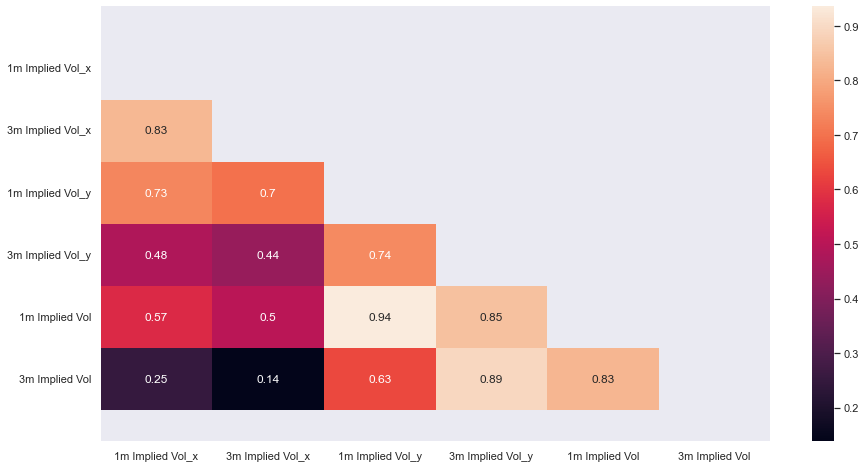

In [338]:
sns.set()
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(data=corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [339]:
population_size = 100
n_generations = 100
risk_free=0.096
GA = Genetic_algorithm(monthly_returns, corr_matrix, risk_free, population_size)

In [340]:
variable = 'return'
GA.run(n_generations,variable)
tree1 = GA.get_tree(variable)
analysis1 = GA.get_analysis()
variable = 'volatility'
GA.run(n_generations,variable)
tree2 = GA.get_tree(variable)
analysis2 = GA.get_analysis()
variable = 'sharpe_ratio'
GA.run(n_generations,variable)
tree3 = GA.get_tree(variable)
analysis3 = GA.get_analysis()

In [341]:
result1_df = tree_to_table(tree1, 'tree_1')
result2_df = tree_to_table(tree2, 'tree_2')
result3_df = tree_to_table(tree3, 'tree_3')
results_df = pd.concat([result1_df, result2_df, result3_df])

In [342]:
results_df.sort_values(by = ['return','volatility'], inplace=True, ascending=[False,True])
b1 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
1985,tree_2,19,85,1.52,0.111805,12.736509
7201,tree_2,72,1,1.51,0.111883,12.638170
641,tree_2,6,41,1.50,0.109483,12.823959
488,tree_1,4,88,1.49,0.113087,12.326753
500,tree_1,5,0,1.49,0.113087,12.326753
...,...,...,...,...,...,...
9714,tree_2,97,14,0.34,0.027738,8.796582
9814,tree_2,98,14,0.34,0.027738,8.796582
9914,tree_2,99,14,0.34,0.027738,8.796582
10014,tree_2,100,14,0.34,0.027738,8.796582


In [343]:
results_df.sort_values(by = ['volatility','return'], inplace=True, ascending=[True,False])
b2 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
9235,tree_3,92,35,0.32,0.021593,10.373623
9619,tree_3,96,19,0.37,0.023985,11.423991
6099,tree_3,60,99,0.40,0.024928,12.195168
1045,tree_3,10,45,0.40,0.024985,12.167380
7573,tree_2,75,73,0.45,0.025163,14.068058
...,...,...,...,...,...,...
9602,tree_1,96,2,1.49,0.113903,12.238509
9702,tree_1,97,2,1.49,0.113903,12.238509
9802,tree_1,98,2,1.49,0.113903,12.238509
9902,tree_1,99,2,1.49,0.113903,12.238509


In [344]:
results_df.sort_values(by='sharpe_ratio', inplace=True, ascending=False)
b3 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
8092,tree_1,80,92,0.60,0.033642,14.981419
9515,tree_1,95,15,0.66,0.037897,14.882597
3900,tree_3,39,0,0.74,0.043523,14.796784
2800,tree_3,28,0,0.74,0.043523,14.796784
2600,tree_3,26,0,0.74,0.043523,14.796784
...,...,...,...,...,...,...
6512,tree_2,65,12,0.34,0.027738,8.796582
6612,tree_2,66,12,0.34,0.027738,8.796582
6712,tree_2,67,12,0.34,0.027738,8.796582
6812,tree_2,68,12,0.34,0.027738,8.796582


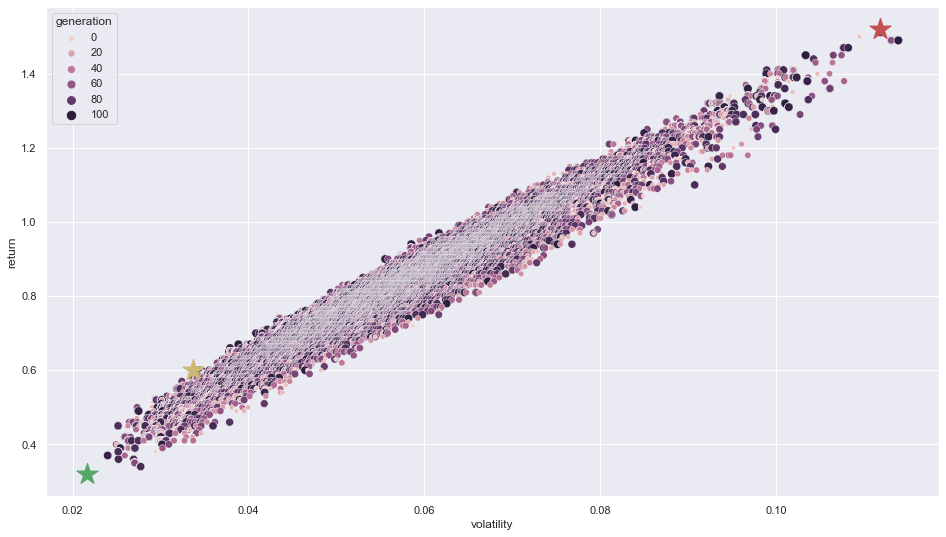

In [345]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = results_df['volatility'],y = results_df['return'], size=results_df['generation'], hue=results_df['generation']) #, style=results_df['name'])
plt.scatter(x = b1['volatility'].iloc[0], y = b1['return'].iloc[0], marker = '*', color = 'r', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b2['volatility'].iloc[0], y = b2['return'].iloc[0], marker = '*', color = 'g', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b3['volatility'].iloc[0], y = b3['return'].iloc[0], marker = '*', color = 'y', s =500, label = 'Max E[Retorno]')

In [346]:
best_portfolios = pd.concat([b1,b2,b3])
best_portfolios

,name,generation,chromosome,return,volatility,sharpe_ratio
1985,tree_2,19,85,1.52,0.111805,12.736509
9235,tree_3,92,35,0.32,0.021593,10.373623
8092,tree_1,80,92,0.60,0.033642,14.981419


In [347]:
stock_names = ['1m Implied Vol_x','3m Implied Vol_x','1m Implied Vol_y','3m Implied Vol_y','1m Implied Vol','3m Implied Vol']



In [348]:
w1 = tree2[best_portfolios['generation'].iloc[0]][best_portfolios['chromosome'].iloc[0]].get_weights()
w2 = tree2[best_portfolios['generation'].iloc[1]][best_portfolios['chromosome'].iloc[1]].get_weights()
w3 = tree1[best_portfolios['generation'].iloc[2]][best_portfolios['chromosome'].iloc[2]].get_weights()
d = {'stock_name': stock_names, 'Weights_Portfolio_Maximum_Returns': w1, 'Weights_Portfolio_Volatility_Minimum': w2, 'Weights_Portfolio_sharperatio_optimo': w3}
best_portfolios_weights = pd.DataFrame(data=d)
best_portfolios_weights

,stock_name,Weights_Portfolio_Maximum_Returns,Weights_Portfolio_Volatility_Minimum,Weights_Portfolio_sharperatio_optimo
0,1m Implied Vol_x,0.025703,0.222685,0.160035
1,3m Implied Vol_x,0.195229,0.232522,0.084964
2,1m Implied Vol_y,0.289610,0.108654,0.209258
3,3m Implied Vol_y,0.122418,0.172742,0.239019
4,1m Implied Vol,0.198949,0.211137,0.179300
5,3m Implied Vol,0.168090,0.052261,0.127423


In [349]:
w1

array([0.02570271, 0.19522898, 0.28961049, 0.12241822, 0.19894945,
       0.16809016])

In [350]:
w2

array([0.22268514, 0.23252164, 0.10865414, 0.17274152, 0.21113655,
       0.05226102])

In [351]:
w3

array([0.1600351 , 0.08496445, 0.20925847, 0.23901886, 0.17930029,
       0.12742284])

In [355]:
returns_array=pd.read_excel("/Users/chinmaythakre/Desktop/MF728 Fixed Income/Project/Returns Array.xlsx",index_col='Date')


In [360]:
returns_array.index

DatetimeIndex(['2018-10-24', '2018-10-25', '2018-10-26', '2018-10-29',
               '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02',
               '2018-11-05', '2018-11-06',
               ...
               '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', name='Date', length=932, freq=None)

0    4.047658
Name: 2018-10-24 00:00:00, dtype: float64

Text(0.5, 1.0, 'Trading Strategy Returns')

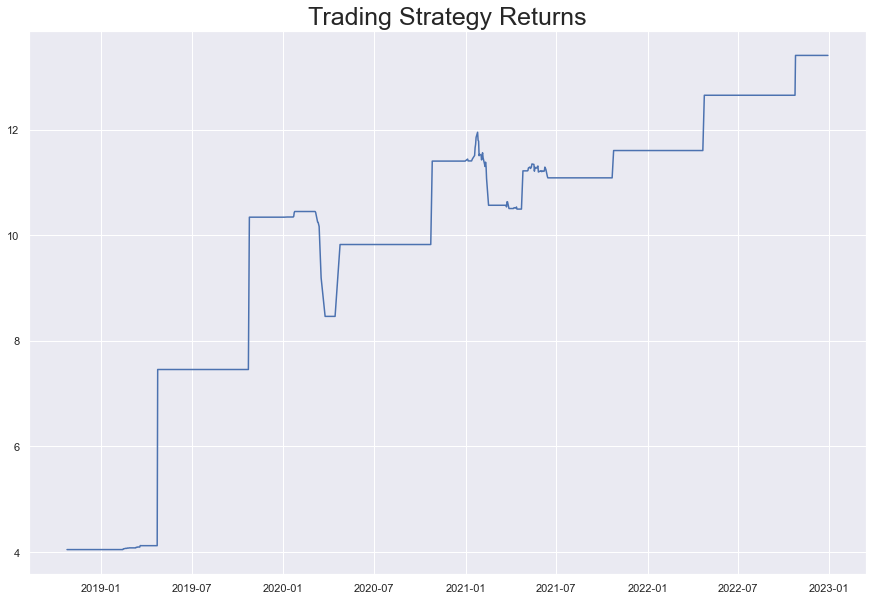

In [367]:
plt.figure(figsize=(15, 10))
plt.plot(returns_array.index, returns_array.iloc[:,0])
plt.title("Trading Strategy Returns",fontdict={'fontsize': 25})
